## Data preprocessing methods

This is just a bunch of shit for going from CHORME data to inputs, as well as training models. You have to input the ways you want to clean the images and which model and whatnot.

In [1]:
import glob
import pickle
import numpy as np
import scipy
import skimage.morphology
import skimage.transform
from sklearn.model_selection import train_test_split
from io import StringIO
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import warnings
from sklearn.neural_network import MLPClassifier
import csv
import warnings
from sklearn.externals import joblib
warnings.filterwarnings('ignore')

def normalize_coordinates(coords, maintain_ar = False):
    min_x = np.min(coords[:,0])
    min_y = np.min(coords[:,1])
    max_x = np.max(coords[:,0])
    max_y = np.max(coords[:,1])
    
    normalized = coords.copy()
    normalized[:,0] = normalized[:,0] - min_x
    normalized[:,1] = normalized[:,1] - min_y
    
    return normalized

def coords_to_image(coords, clean=True):
    normalized = normalize_coordinates(coords)
    
    M = np.max(normalized[:,0]) + 1
    N = np.max(normalized[:,1]) + 1
    
    image = np.zeros((M,N))
        
    for coord in normalized:
        image[coord[0],coord[1]] = 1

    return image.transpose((1,0))
    
def stroke_to_arr(stroke):
    stroke = stroke.replace(',', '\n')
    stroke_IO = StringIO(stroke)
    stroke_arr = np.loadtxt(stroke_IO)
    return stroke_arr

def parse_meta(inkml_file):
    tree = ET.parse(inkml_file)
    root = tree.getroot()
    
    annotation = root.find("{http://www.w3.org/2003/InkML}annotation")
    return annotation.text
    
def parse_traces(inkml_file):
    tree = ET.parse(inkml_file)
    root = tree.getroot()
    traces = root.findall("{http://www.w3.org/2003/InkML}trace")
    d_traces = []
    for trace in traces:
        d_trace = stroke_to_arr(trace.text)
        if(len(d_trace.shape)==1):
            d_trace = d_trace.reshape(1,d_trace.shape[0])
        d_traces.append(d_trace)
    return np.array(d_traces)

def inkml_to_image(inkml_file):
    traces = parse_traces(inkml_file)
    image_id = parse_meta(inkml_file)
    coords = []
    for trace in traces:
        coords.extend(trace)
    coords = np.array(coords)
    return image_id, coords_to_image(coords,False) 

def image_to_input(image):
    NORMALIZED_IMAGE_SHAPE = image.shape
    return image.flatten()

def input_to_image(X):
    return X.reshape(NORMALIZED_IMAGE_SHAPE)

BAD_LABELS = [" junk", "junk"]
REL_PATH = os.path.join(".","data","isolatedTest2014")
TRUTH_FILE = os.path.join(REL_PATH, "iso_GT.txt")
MODELS_PATH = './pickle_files/models/model'
DATA_PATH = './pickle_files/data/'
IMAGES_PATH = './pickle_files/images/'
ORIGINAL_IMAGES_LIST = './pickle_files/static/image_list'
GROUND_TRUTH_SYMBOLS_LIST = './pickle_files/static/symbols_list'
NORMALIZED_IMAGE_SHAPE = (50,50)

def compute_everything(cleaning_func, model, version=None):
    
    # build cleaned_images list
    original_images, ground_truth_symbols = get_static(remove_bad_labels=True)
    cleaned_images = []
    for image in tqdm(original_images):
        cleaned_image = cleaning_func(image)
        cleaned_images.append(cleaned_image)
         
    # build inputs: convert relevant images to inputs
    X = []
    y = []
    for image,symbol in zip(cleaned_images, ground_truth_symbols):
        input_image = image_to_input(image)
        X.append(input_image)
        y.append(symbol)
        
    # train model
    if(model):
        model.fit(X, y)
    else:
        model = MLPClassifier(verbose=verbose)
        model.fit(X, y)

    # store if there's a version associated with it
    if(version):
        store_everything(version, cleaned_images, X, y, model)

    return cleaned_images, X, y, model

def get_everything(version=1):
    model = joblib.load(MODELS_PATH + str(version))
    X = joblib.load(DATA_PATH + "/X" + str(version))
    y = joblib.load(DATA_PATH + "/y" + str(version))
    cleaned_images = joblib.load(IMAGES_PATH + "/cleaned_images" + str(version))
    return cleaned_images, X, y, model

def store_everything(version, cleaned_images, X, y, model):
    joblib.dump(model, MODELS_PATH + str(version))
    joblib.dump(X, DATA_PATH + "/X" + str(version))
    joblib.dump(y, DATA_PATH + "/y" + str(version))
    joblib.dump(cleaned_images, IMAGES_PATH + "/cleaned_images"  + str(version))
    
def build_static():
    original_images = []
    ground_truth_symbols = []
    symbol_dict = {}
    with open(TRUTH_FILE, "rt") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            symbol_dict[str(row[0])] = row[1]
    inkml_files = glob.glob(os.path.join(REL_PATH,"*.inkml"))
    for inkml_file in tqdm(inkml_files):
        image_id, image = inkml_to_image(inkml_file)
        symbol = symbol_dict[str(image_id)] 
        original_images.append(image)
        ground_truth_symbols.append(symbol)
        
    original_images = np.array(original_images)
#     print(original_images[0].shape)
#     print(original_images.shape)
#     print(len(ground_truth_symbols))
    joblib.dump(original_images, ORIGINAL_IMAGES_LIST)
    joblib.dump(ground_truth_symbols, GROUND_TRUTH_SYMBOLS_LIST)
#     original_images, ground_truth_symbols = get_static(True)
#     print(original_images.shape)
#     print(len(ground_truth_symbols))
    
    return original_images, ground_truth_symbols
    
    
def get_static(remove_bad_labels = True):      
    original_images = joblib.load(ORIGINAL_IMAGES_LIST) 
    ground_truth_symbols = joblib.load(GROUND_TRUTH_SYMBOLS_LIST)
    
    if(remove_bad_labels):
        images = []
        symbols = []
        for image,symbol in zip(original_images,ground_truth_symbols):
            if(symbol not in BAD_LABELS):
                images.append(image)
                symbols.append(symbol)
        return np.array(images), symbols    
    
    return original_images, ground_truth_symbols



## Different cleaning and model methods

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

model_v1 = MLPClassifier()
def clean_v1(image):
    diff = 5
    image = np.pad(image, diff, mode='constant', constant_values=(0,0))
    image = skimage.transform.resize(image, NORMALIZED_IMAGE_SHAPE)
    return image

model_v2 = MLPClassifier()
def clean_v2(image):
    image = clean_v1(image)
    image = np.where(image, 1, 0)
    return image

## Visualization and evaluation methods

In [3]:
def visualize_everything(version):
    print('Version: ' + str(version))
    print('Loading model...')
    cleaned_images, X, y, model = get_everything(version)
    print('Accuracy over all data: ' + str(model.score(X,y)))
    print('Loading truth...')
    original_images, ground_truth_symbols = get_static(True)
    predicted_symbols = model.predict(X)
    visualize_images_and_symbols(original_images, cleaned_images, ground_truth_symbols, predicted_symbols)

def make_predictions(model, X):
    return model.predict(X)

def visualize_images_and_symbols(images, cleaned_images, y_true, y_pred):
    for original_image, cleaned_image, y, y_p in zip(images[0:20], cleaned_images[0:20], y_true[0:20], y_pred[0:20]):
        print('Actual: ' + str(y) + "   |   " + "Predicted: " + str(y_p))
#         plt.subplot(121)
#         plt.title('Original: ' + str(original_image.shape))
#         plt.axis('off')
#         plt.imshow(original_image, cmap="Greys")
#         plt.subplot(122)
        plt.title('Cleaned image')
        plt.axis('off')
        plt.imshow(cleaned_image, cmap="Greys")
        plt.show()

## Temporary

Version: 2
Loading model...
Accuracy over all data: 0.997813338634
Loading truth...
Actual: x   |   Predicted: x


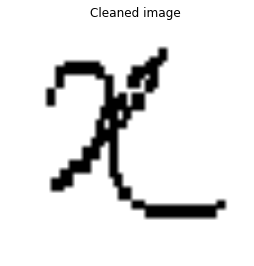

Actual: k   |   Predicted: k


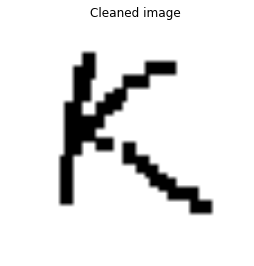

Actual: x   |   Predicted: x


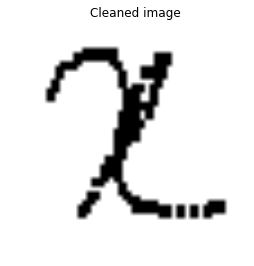

Actual: x   |   Predicted: x


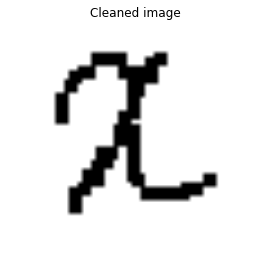

Actual: 0   |   Predicted: 0


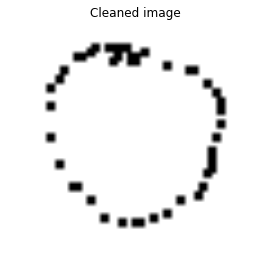

Actual: \infty   |   Predicted: \infty


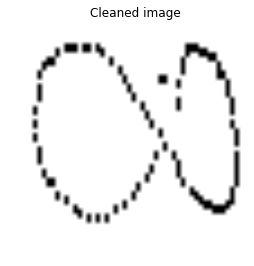

Actual: 4   |   Predicted: 4


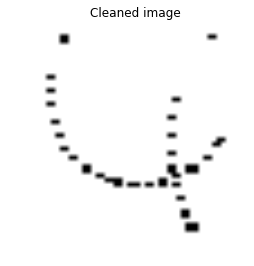

Actual: n   |   Predicted: n


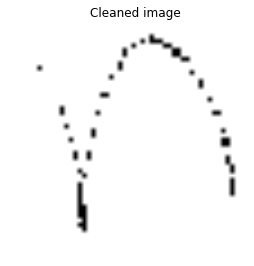

Actual: \lim   |   Predicted: \lim


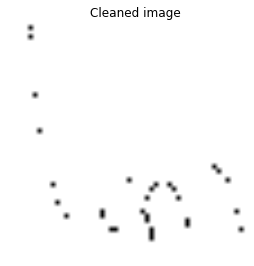

Actual: 1   |   Predicted: 1


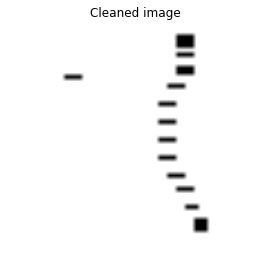

Actual: 2   |   Predicted: 2


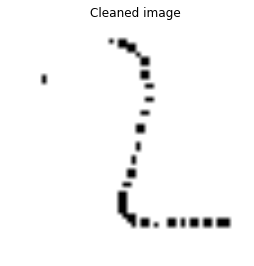

Actual: 0   |   Predicted: 0


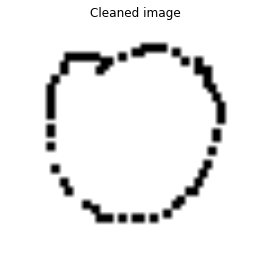

Actual: n   |   Predicted: n


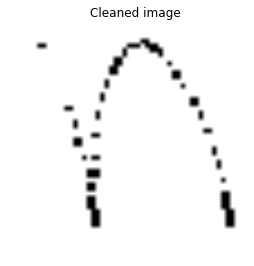

Actual: 2   |   Predicted: 2


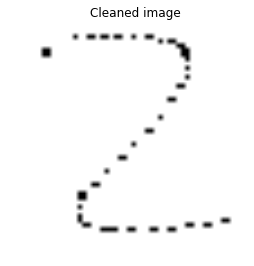

Actual: -   |   Predicted: -


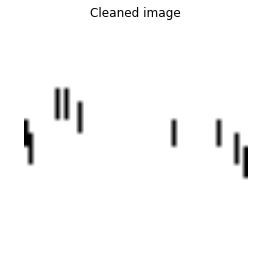

Actual: -   |   Predicted: -


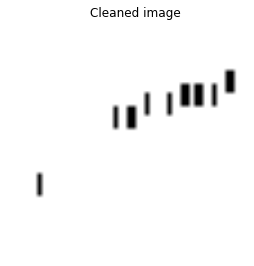

Actual: 3   |   Predicted: 3


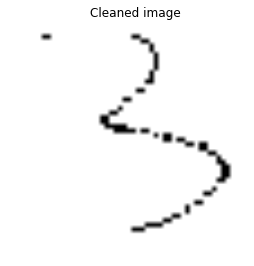

Actual: 3   |   Predicted: 3


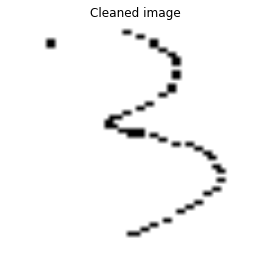

Actual: +   |   Predicted: +


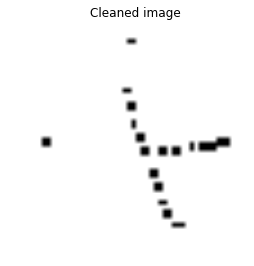

Actual: n   |   Predicted: n


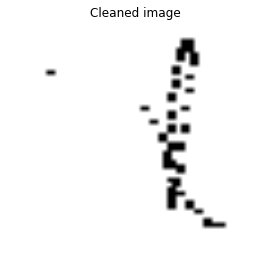

In [4]:
# compute_everything(clean_v2, model_v2, version=2)
visualize_everything(2)